In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import glob
from skimage.feature import local_binary_pattern
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load the dataset labels
labels_csv_path = '/content/gdrive/MyDrive/labnotebook/9517/labels.csv'
labels = pd.read_csv(labels_csv_path, header=None, names=["image", "prob_defect", "Module_Type"], sep="\\s+")

# Define paths
images_path = '/content/gdrive/MyDrive/labnotebook/9517/images/*.png'
lbp_images_path = '/content/gdrive/MyDrive/labnotebook/9517/imagens_lbp'

# Process and store grayscale images and labels
imgs_lbp = [] # List to store LBP images
labels_list = labels['prob_defect'].tolist()

# Check if LBP images directory exists, if not create it
if not os.path.exists(lbp_images_path):
    os.makedirs(lbp_images_path)

# Process each image for LBP
for img_path in sorted(glob.glob(images_path)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_lbp = local_binary_pattern(img, 8, 1, method='uniform')
    imgs_lbp.append(img_lbp)

# Convert LBP images into a numpy array
X = np.array([img.flatten() for img in imgs_lbp], dtype='float32')

# Normalize the data
X = X / 255.0

# Reshape X to add channel dimension (1 for grayscale)
X = X.reshape((-1, img.shape[0], img.shape[1], 1))

# Split the dataset
x_train, x_val, y_train, y_val = train_test_split(X, np.array(labels_list), test_size=0.25, stratify=labels_list)

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define model parameters
c_entrada = [32, 64, 128]
c_dense = [256, 4]
kernel = (3, 3)
strd = 1
pool = (2, 2)
act_func_conv = 'relu'
act_func_output = 'softmax'
dropout_rate = 0.5

# Model architecture
model_cnn = models.Sequential([
    # Convolutional Layers
    layers.Conv2D(c_entrada[0], kernel, strides=strd, activation=act_func_conv, input_shape=(img.shape[0], img.shape[1], 1)),
    layers.MaxPooling2D(pool),
    BatchNormalization(),
    layers.Conv2D(c_entrada[1], kernel, strides=strd, activation=act_func_conv),
    layers.MaxPooling2D(pool),
    BatchNormalization(),
    layers.Conv2D(c_entrada[2], kernel, strides=strd, activation=act_func_conv),
    layers.MaxPooling2D(pool),
    BatchNormalization(),

    # Flattening and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(c_dense[0], activation=act_func_conv),
    Dropout(dropout_rate),
    layers.Dense(c_dense[1], activation=act_func_output)
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model_cnn.fit(datagen.flow(x_train, y_train, batch_size=32),
                        epochs=60, validation_data=(x_val, y_val))

# Save the model and training history
model_save_path = '/content/gdrive/MyDrive/labnotebook/9517/my_model.h5'
history_save_path = '/content/gdrive/MyDrive/labnotebook/9517/history.json'
model_cnn.save(model_save_path)
with open(history_save_path, 'w') as file:
    json.dump(history.history, file)

# Print dataset information
print(f'Number of samples in x_train: {len(x_train)}')
print(f'Number of samples in y_train: {len(y_train)}')
print(f'Number of samples in x_val: {len(x_val)}')
print(f'Number of samples in y_val: {len(y_val)}')
print(f"Unique classes in y_train: {np.unique(y_train)}")
print(f"Unique classes in y_val: {np.unique(y_val)}")


Mounted at /content/gdrive
Epoch 1/60
62/62 [==============================] - 30s 272ms/step - loss: 9.9782 - accuracy: 0.5483 - val_loss: 1.7941 - val_accuracy: 0.5747
Epoch 2/60
62/62 [==============================] - 17s 273ms/step - loss: 2.2011 - accuracy: 0.5447 - val_loss: 1.6490 - val_accuracy: 0.5747
Epoch 3/60
62/62 [==============================] - 17s 272ms/step - loss: 0.8866 - accuracy: 0.5777 - val_loss: 2.5219 - val_accuracy: 0.5747
Epoch 4/60
62/62 [==============================] - 17s 273ms/step - loss: 0.6930 - accuracy: 0.5823 - val_loss: 3.8961 - val_accuracy: 0.5747
Epoch 5/60
62/62 [==============================] - 17s 274ms/step - loss: 0.6971 - accuracy: 0.5874 - val_loss: 3.8996 - val_accuracy: 0.5747
Epoch 6/60
62/62 [==============================] - 17s 274ms/step - loss: 0.6374 - accuracy: 0.5940 - val_loss: 3.3304 - val_accuracy: 0.2729
Epoch 7/60
62/62 [==============================] - 17s 274ms/step - loss: 0.6163 - accuracy: 0.6011 - val_loss: 2.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Number of samples in x_train: 1968
Number of samples in y_train: 1968
Number of samples in x_val: 656
Number of samples in y_val: 656
Unique classes in y_train: [0.         0.33333333 0.66666667 1.        ]
Unique classes in y_val: [0.         0.33333333 0.66666667 1.        ]


21/21 [==============================] - 0s 11ms/step
Confusion Matrix
[[450  27]
 [126  53]]


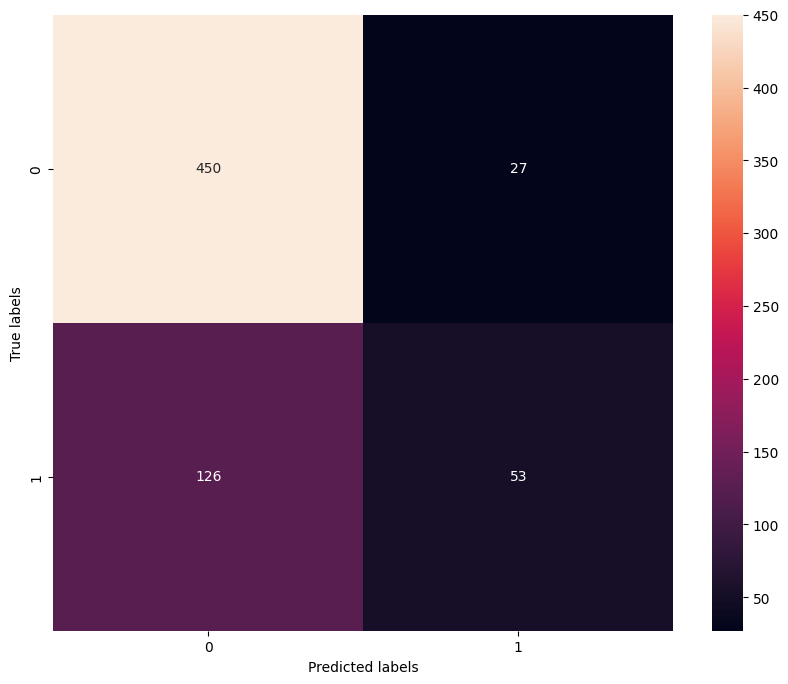

In [2]:
import tensorflow as tf
from tensorflow.math import confusion_matrix

# Evaluate the model
y_pred = model_cnn.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Convert confusion matrix from tensor to numpy array if you want to print or process it further
cm_array = cm.numpy()

# Print the confusion matrix
print('Confusion Matrix')
print(cm_array)

# You can also visualize the confusion matrix using seaborn for better readability
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm_array, annot=True, fmt='g')  # 'g' means generic format which could be either integer or float
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [3]:
import numpy as np

# Assuming y_pred_classes and y_val are already defined and contain the predicted and true labels respectively

# Get the number of classes from the data
num_classes = len(np.unique(np.concatenate((y_val, y_pred_classes))))

# Initialize arrays to hold the precision, recall, and F1-score
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

# Compute precision, recall, and F1-score for each class
for i in range(num_classes):
    true_positive = np.sum((y_val == i) & (y_pred_classes == i))
    false_positive = np.sum((y_val != i) & (y_pred_classes == i))
    false_negative = np.sum((y_val == i) & (y_pred_classes != i))

    # Calculate metrics for the current class
    precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# Print the classification report
print('Classification Report')
for i in range(num_classes):
    print(f'Class {i}:')
    print(f'    Precision: {precision[i]:.2f}')
    print(f'    Recall: {recall[i]:.2f}')
    print(f'    F1-Score: {f1_score[i]:.2f}')

# Overall accuracy
accuracy = np.sum(y_val == y_pred_classes) / len(y_val)
print(f'Accuracy: {accuracy:.2f}')


Classification Report
Class 0:
    Precision: 0.62
    Recall: 0.95
    F1-Score: 0.75
Class 1:
    Precision: 0.66
    Recall: 0.30
    F1-Score: 0.41
Class 2:
    Precision: 0.00
    Recall: 0.00
    F1-Score: 0.00
Class 3:
    Precision: 0.00
    Recall: 0.00
    F1-Score: 0.00
Accuracy: 0.63


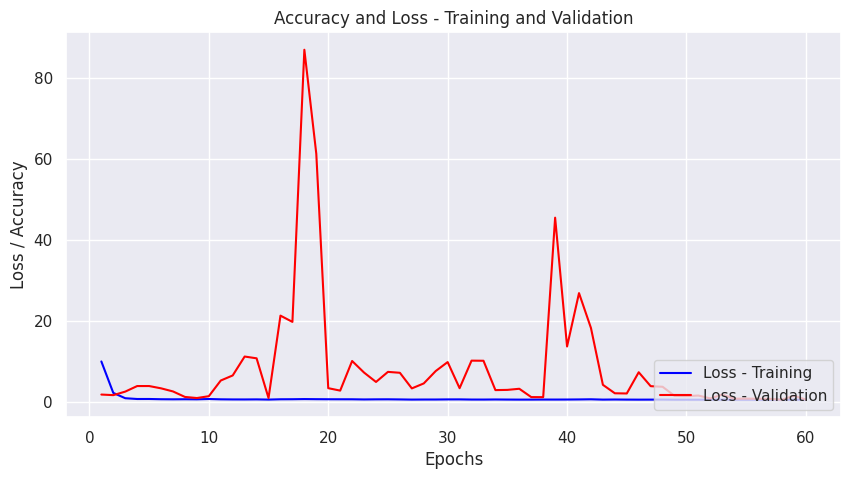

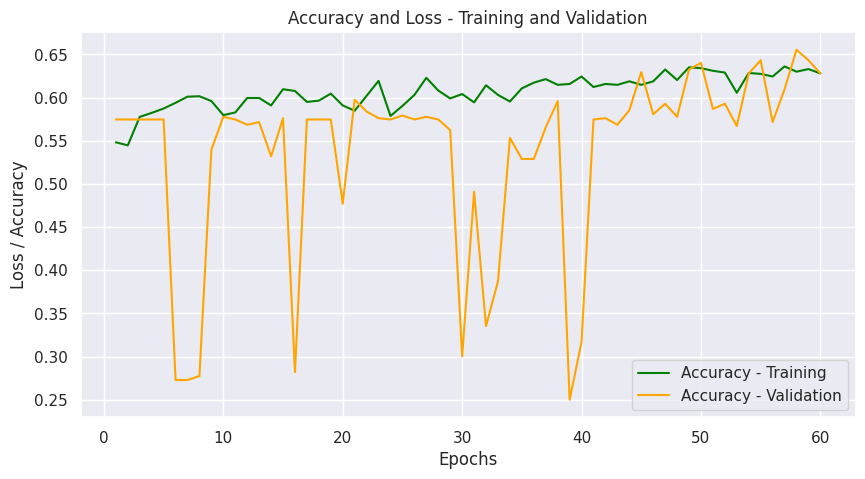

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the loss and accuracy values from the history.
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define the number of epochs.
epochs = range(1, len(loss) + 1)

# Plot the graphs.
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(epochs, loss, label='Loss - Training', color='blue')
ax.plot(epochs, val_loss, label='Loss - Validation', color='red')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Accuracy and Loss - Training and Validation')
ax.legend(loc='lower right')

plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, acc, label='Accuracy - Training', color='green')
ax.plot(epochs, val_acc, label='Accuracy - Validation', color='orange')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')
ax.set_title('Accuracy and Loss - Training and Validation')
ax.legend(loc='lower right')

plt.show()

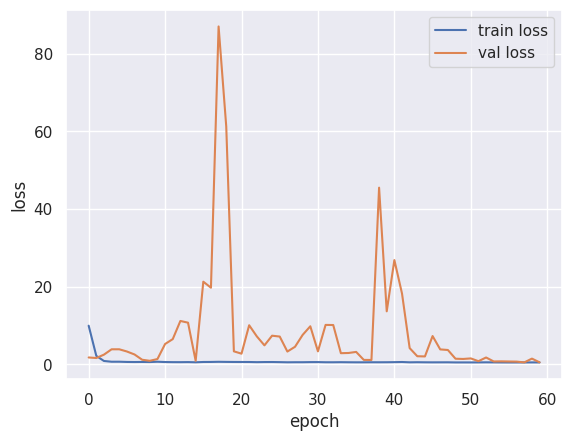

In [5]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss graph as a function of training.
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()